## Capstone - Football Player Scouting: EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from mplsoccer import PyPizza, FontManager

***

## Introduction <a class="anchor" id="1"></a>

The goal is to deliver a tool that will support football clubs in their scouting and transfer processes by: 
- Delivering accurate market values of football players,
- Identification of players within specific groups through data,
- Recommending similar players to high value, famous players who are less expensive. 

The end state will provide teams with the ability to find undervalued players, similar to a high-profile player they would like to sign, but for less money and with more 'value' based on modelling how much a player should be worth with only consideration for their playing statistics. 

The premise is that player values are determined not only by statistics but by many other factors such as how famous they are, how much publicity they have had, performance in one big tournament. This analysis will focus only on a players raw statistics as a factor for performance and identificiation. 

Data: https://drive.google.com/drive/folders/1ePqWsQ24m9TTHsZbgTmQ0nIz-uSTCAWR?usp=sharing

In [5]:
# Import dataframe from data cleaning 
player_df = pd.read_csv('../Notebook_Data_Exports/data_preprocessing.csv')

In [7]:
# Check for duplicate rows - Removed in first part of analysis
player_df.duplicated().sum()

0

In [8]:
# Check for duplicate columns - These are not true duplicates
player_df.T.duplicated().sort_values().tail(5)

shots_per90_percentile_overall           False
shots_on_target_per_90_overall           False
market_value_in_eur                      False
three_goals_in_a_game_total_overall       True
aerial_duels_per90_percentile_overall     True
dtype: bool

In [9]:
# Check for zeros in columns - this is expected, not all players will have stats for specific features
zeros_count_per_column = (player_df == 0).sum(axis=0).reset_index(name = 'Zero Count')
zeros_count_per_column.sort_values('Zero Count', ascending = False).head(10)

index  Zero Count
141               pen_save_percentage_overall        8051
216  three_goals_in_a_game_percentage_overall        7962
212                   hattricks_total_overall        7954
214       three_goals_in_a_game_total_overall        7954
145                  pens_saved_total_overall        7859
130                  pen_missed_total_overall        7752
24                             penalty_misses        7734
185          punches_per90_percentile_overall        7586
152                    punches_per_90_overall        7581
151                  punches_per_game_overall        7581

### EDA: Feature reduction through reduction of columns

In [10]:
# Check for combinations of 0 / NaN in columns - To drop
blend_columns = []
for column in player_df.columns:
    if player_df[column].isin([0, 0.0,'', np.nan]).all():
        blend_columns.append(column)
print(blend_columns)

['pen_save_percentage_overall']


In [11]:
# These columns have been dropped already due to null values and duplication
columns_to_drop_v1 = ['annual_salary_usd', 
                  'annual_salary_gbp',
                  'man_of_the_match_total_overall',
                  'distance_travelled_per90_percentile_overall',
                  'distance_travelled_per_90_overall',
                  'distance_travelled_total_overall',
                  'progressive_passes_total_overall',
                  'aerial_duels_won_percentage_overall',
                  'aerial_duels_per_90_overall',
                  'aerial_duels_total_overall',
                  'sm_minutes_played_per90_percentile_overall',
                  'market_value_percentile',
                  'market_value',
                  'pressures_per90_percentile_overall',
                  'pressures_per_90_overall',
                   'pressures_total_overall',
                  'xg_faced_total_overall',
                  'xg_faced_per_game_overall',
                  'xg_faced_per90_percentile_overall',
                  'xg_faced_per_90_overall',
                  'shots_per_goal_conceded_overall',
                  'chances_created_per90_percentile_overall',
                  'chances_created_per_90_overall',
                  'chances_created_total_overall',
                  'short_passes_per90_percentile_overall',
                  'short_passes_per_90_overall',
                  'short_passes_total_overall',
                  'long_passes_per90_percentile_overall',
                  'long_passes_per_90_overall',
                  'long_passes_total_overall',
                  'through_passes_per_90_overall',
                  'through_passes_total_overall',
                  'tackles_successful_total_overall',
                  'tackles_successful_per90_percentile_overall',
                  'tackles_successful_per_90_overall',
                  'additional_info',
                  'possession_regained_per90_percentile_overall',
                  'possession_regained_total_overall',
                  'possession_regained_per_90_overall',
                  'aerial_duels_per_game_overall',
                  'chances_created_per_game_overall',
                  'distance_travelled_per_game_overall',
                  'pressures_per_game_overall',
                  'possession_regained_per_game_overall',
                  'tackles_successful_per_game_overall',
                  'through_passes_per_game_overall',
                  'long_passes_per_game_overall',
                  'short_passes_per_game_overall',
                  'save_percentage_percentile_overall']

In [12]:
# A second review of all columns from the original data from was conducted: 
columns_to_drop_v2 = ['birthday', 'appearances_home', 'appearances_away', 'goals_overall', 'goals_away',
                   'assists_overall', 'assists_home', 'assists_away', 'clean_sheets_home', 'clean_sheets_away', 
                   'conceded_home', 'conceded_away', 'goals_per_90_home', 'min_per_conceded_overall', 'min_per_card_overall',
                   'min_per_assist_overall', 'assists_per_game_overall', 'sm_assists_total_overall', 'passes_per_game_overall', 
                   'passes_total_overall', 'passes_completed_per_game_overall', 'passes_completed_total_overall', 'passes_per_game_overall', 
                   'short_passes_per_game_overall', 'long_passes_per_game_overall', 'key_passes_total_overall', 'through_passes_per_game_overall',
                   'tackles_per_game_overall', 'tackles_total_overall', 'tackles_successful_per_game_overall', 'possession_regained_per_game_overall', 
                   'pressures_per_game_overall', 'distance_travelled_per_game_overall', 'chances_created_per_game_overall', 
                   'aerial_duels_per_game_overall', 'possession_regained_per_90_overall', 'possession_regained_total_overall', 
                   'possession_regained_per90_percentile_overall', 'additional_info', 'shots_total_overall', 
                   'shots_on_target_total_overall', 'shots_off_target_total_overall', 'tackles_successful_per_90_overall', 
                   'tackles_successful_per90_percentile_overall', 'tackles_successful_total_overall', 'interceptions_total_overall', 
                   'crosses_total_overall', 'crosses_per_90_overall', 'through_passes_total_overall', 'through_passes_per_90_overall', 
                   'through_passes_per90_percentile_overall', 'long_passes_total_overall', 'long_passes_per_90_overall', 'short_passes_total_overall', 
                   'short_passes_per_90_overall', 'short_passes_per90_percentile_overall', 'dribbles_total_overall', 'dribbles_successful_total_overall', 
                   'chances_created_total_overall', 'chances_created_per_90_overall', 'chances_created_per90_percentile_overall', 
                   'shots_per_goal_conceded_overall', 'sm_goals_conceded_total_overall', 'xg_faced_per_90_overall', 'xg_faced_per90_percentile_overall',
                   'xg_faced_per_game_overall', 'xg_faced_total_overall', 'pressures_total_overall', 'pressures_per90_percentile_overall', 
                   'market_value', 'market_value_percentile', 'sm_goals_scored_total_overall', 'dribbled_past_per_game_overall', 
                   'dribbled_past_total_overall', 'dribbles_successful_percentage_percentile_overall', 'blocks_per_game_overall', 
                   'blocks_total_overall', 'ratings_total_overall', 'clearances_per_game_overall', 'clearances_total_overall', 
                   'pen_committed_total_overall', 'pen_save_percentage_overall', 'pen_committed_per_90_overall',  
                   'pen_committed_per_game_overall', 'pens_taken_total_overall', 'hit_woodwork_total_overall', 
                   'hit_woodwork_per_game_overall', 'punches_total_overall', 'punches_per_game_overall', 'offsides_per_game_overall', 
                   'offsides_total_overall', 'sm_minutes_played_per90_percentile_overall', 'sm_minutes_played_recorded_overall', 
                   'min_per_goal_percentile_overall', 'min_per_conceded_percentile_overall', 'xa_total_overall', 'xa_per_game_overall', 
                   'npxg_total_overall', 'npxg_per_game_overall', 'fouls_drawn_total_overall', 'fouls_drawn_per_game_overall', 
                   'fouls_committed_per_game_overall', 'fouls_committed_total_overall', 'aerial_duels_total_overall', 'aerial_duels_won_total_overall', 
                   'aerial_duels_won_percentage_overall', 'aerial_duels_per_90_overall', 'duels_per_game_overall', 'duels_total_overall', 
                   'duels_won_total_overall', 'dispossesed_total_overall', 'progressive_passes_total_overall', 'distance_travelled_total_overall', 
                   'distance_travelled_per_90_overall', 'distance_travelled_per90_percentile_overall', 'accurate_crosses_total_overall', 
                   'accurate_crosses_per_game_overall', 'sm_matches_recorded_total_overall', 'goals_per90_percentile_away', 
                   'goals_per90_percentile_home', 'man_of_the_match_total_overall', 'booked_over05_overall', 'booked_over05_percentage_overall', 
                   'booked_over05_percentage_overall', 'annual_salary_gbp', 'annual_salary_usd', 'minutes_played_home', 
                     'minutes_played_away']

In [13]:
# Additional columns to drop, based on a cross check between columns dropped previously and the new assessment
columns_to_drop = [feature for feature in columns_to_drop_v2 if feature not in columns_to_drop_v1]

In [15]:
# Drop columns from df: Based on a detailed manual review of each column 
player_df_dropped = player_df.drop(columns = columns_to_drop)

In [16]:
# Separate data frames - to be used in feature engineering (Per 90 statistics vs overall vs percentile)

# The purpose of this analysis is to focus on pure statistics, hence percentiles have been removed

# Split columns with percentiline information 
columns_with_percentiles = [columns for columns in player_df_dropped.columns if 'percentile' in columns]
columns_without_percentiles = [columns for columns in player_df_dropped.columns if 'percentile' not in columns]

#Review columns with only per 90 (per game) statistics
columns_specifically_per90 = [columns for columns in columns_without_percentiles if '90' in columns]
remaining_not_per90 = [columns for columns in columns_without_percentiles if '90' not in columns]

In [17]:
# Create reduced data frame with columns of interest based on a blend of per 90 statistics and others of interest
# The league, season, position, current club and nationality are categorical columns 
player_df_reduced_df = player_df_dropped.loc[:, ['full_name',
 'age',
 'league',
 'season',
 'position',
 'Current Club',
 'nationality',
 'file_name',
 'player_year_key',
 'minutes_played_overall',
 'appearances_overall',
 'penalty_goals', # convert to per 90
 'penalty_misses', # convert to per 90
'clean_sheets_overall', # convert to per 90
 'goals_involved_per_90_overall',
 'assists_per_90_overall',
 'goals_per_90_overall',
 'conceded_per_90_overall',
 'cards_per_90_overall',
 'passes_per_90_overall',
 'passes_completed_per_90_overall',
 'tackles_per_90_overall',
 'shots_per_90_overall',
 'shots_on_target_per_90_overall',
 'shots_off_target_per_90_overall',
 'interceptions_per_90_overall',
 'key_passes_per_90_overall',
 'dribbles_per_90_overall',
 'dribbles_successful_per_90_overall',
 'saves_per_90_overall',
 'shots_faced_per_90_overall',
 'dribbled_past_per_90_overall',
 'blocks_per_90_overall',
 'clearances_per_90_overall',
 'hit_woodwork_per_90_overall',
 'punches_per_90_overall',
 'offsides_per_90_overall',
 'xa_per_90_overall',
 'npxg_per_90_overall',
 'fouls_drawn_per_90_overall',
 'fouls_committed_per_90_overall',
 'xg_per_90_overall',
 'aerial_duels_won_per_90_overall',
 'duels_per_90_overall',
 'duels_won_per_90_overall',
 'dispossesed_per_90_overall',
 'accurate_crosses_per_90_overall',
 'rank_in_league_top_attackers',
 'rank_in_league_top_midfielders',
 'rank_in_league_top_defenders',
 'rank_in_club_top_scorer',
 'average_rating_overall',
'crosses_per_game_overall', # Per game is ok
 'dispossesed_per_game_overall', # Per game is ok
 'saves_per_game_overall', # Per game is ok
 'shots_per_goal_scored_overall', # Non per 90
 'shots_off_target_per_game_overall', # Per game is ok
 'dribbles_successful_percentage_overall', # What to do with %
 'save_percentage_overall', # What to do with this
 'pass_completion_rate_overall',
 'shot_accuraccy_percentage_overall',
 'inside_box_saves_total_overall', # convert to per90
 'penalties_won_total_overall', # convert to per90
 'shot_conversion_rate_overall', # what to do with this
 'duels_won_per_game_overall',
 'duels_won_percentage_overall',
 'cross_completion_rate_overall',
 'hattricks_total_overall', # convert to per90
 'two_goals_in_a_game_total_overall', # convert to per90
 'three_goals_in_a_game_total_overall', # convert to per90
 'annual_salary_eur',
 'market_value_in_eur']]
 


### The final data frame

The final data frame consists of: 
- Per 90 statistics from variables that consider all positions (Goalkeeper, Defender, Midfielder, Forward)
- Categorical data in relation to the players club, league, position, season, and nationality
- Other interesting metrics that could influence value: Age, Average Rating, Salary, % statistics e.g. Shot Conversion Rate, which is not explicity linked to the per 90 statistics.  

# Basic EDA

In [18]:
# Slice for only players who have played more than 400 minutes in each season
# Players who have played few minutes can have distorted statistics and are not representative of consistency
# This also significantly removed outliers in the data, a retrospective action
player_df_reduced = player_df_reduced_df[player_df_reduced_df['minutes_played_overall']>400]

### Target Variable: Market Value

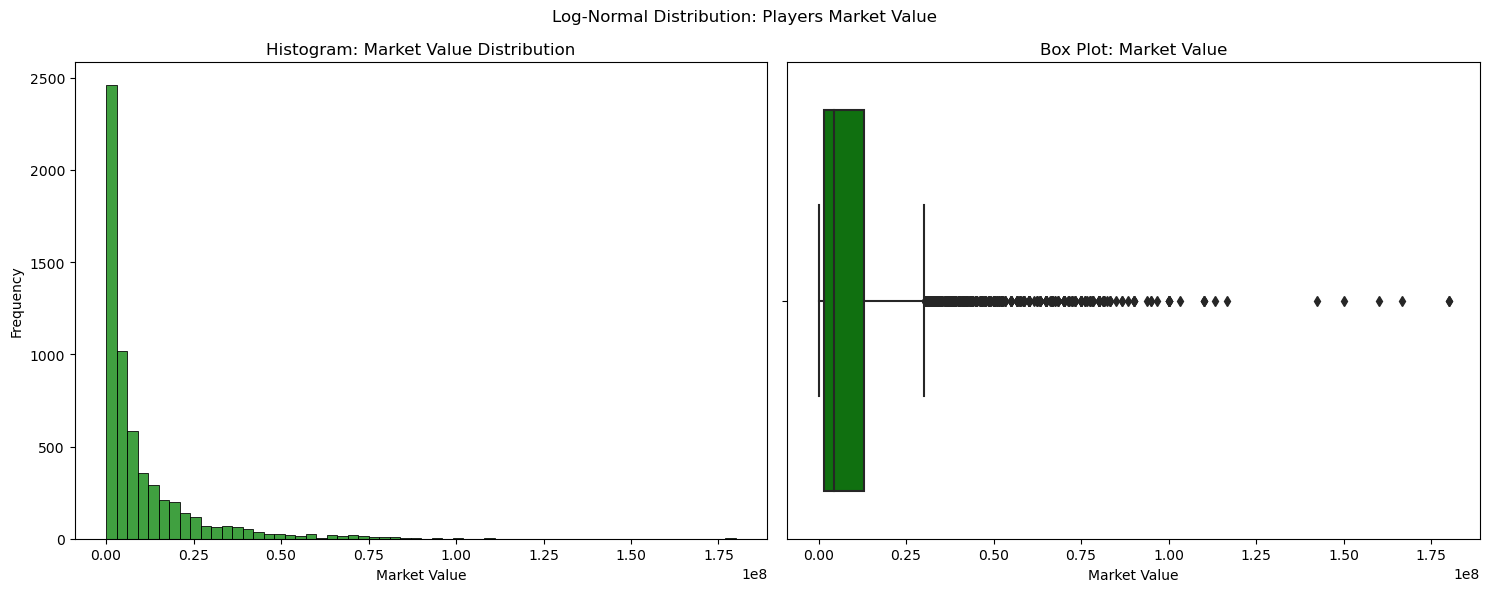

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
sns.histplot(player_df_reduced['market_value_in_eur'], bins=60, color='green', ax=axes[0])
axes[0].set_xlabel('Market Value')
axes[0].set_ylabel('Frequency')

# Box plot
sns.boxplot(x=player_df_reduced['market_value_in_eur'], ax=axes[1], color = 'green')
axes[1].set_xlabel('Market Value')

axes[0].set_title('Histogram: Market Value Distribution')
axes[1].set_title('Box Plot: Market Value')

# Set overall title
plt.suptitle('Log-Normal Distribution: Players Market Value')

# Adjust layout
plt.tight_layout()

In [22]:
# Review of distribution and averages of Market Value
player_df_reduced['market_value_in_eur'].describe()

count    5.974000e+03
mean     1.051212e+07
std      1.567729e+07
min      5.000000e+04
25%      1.500000e+06
50%      4.333333e+06
75%      1.300000e+07
max      1.800000e+08
Name: market_value_in_eur, dtype: float64

#### Insights
- A significant number of players have a market value of 0 million
- 75% of players have a market value of less than 13 million
- There are significant outliers in the data, this is expected due to some extremely high value players
- This analysis will identify if purely due to their statistics, they should be this expensive

### Most Valuable Players: Market Value

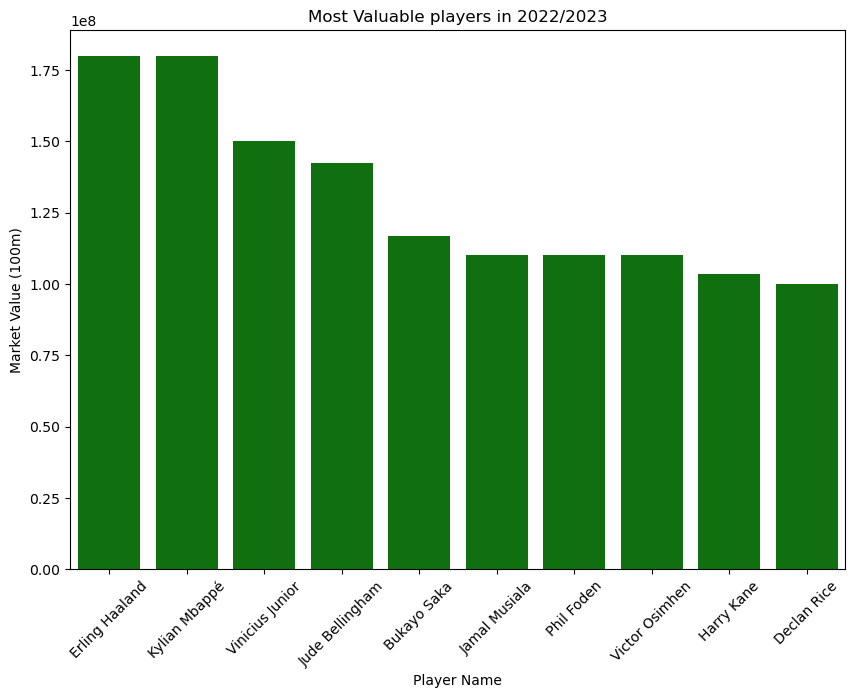

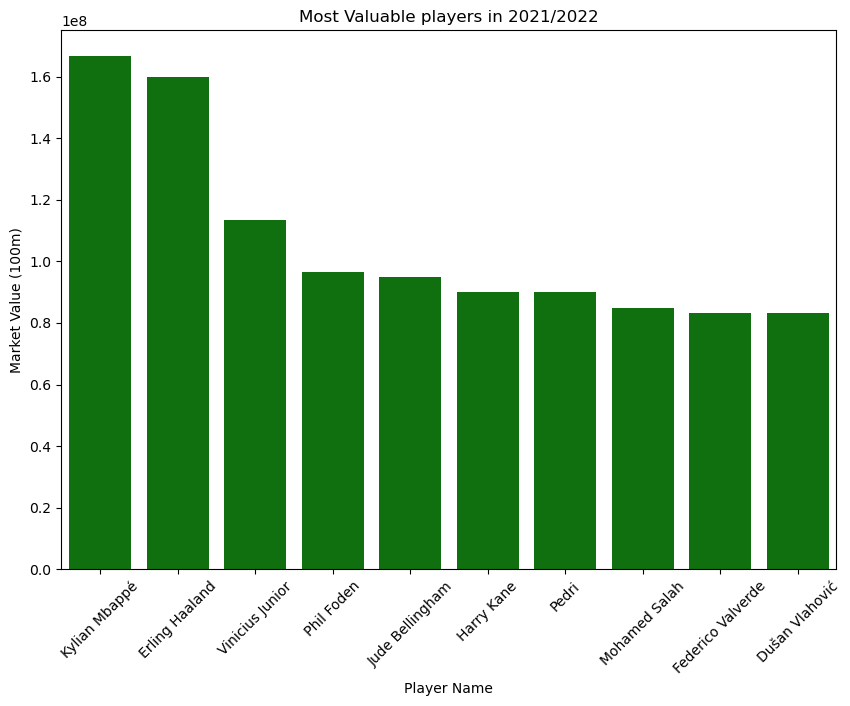

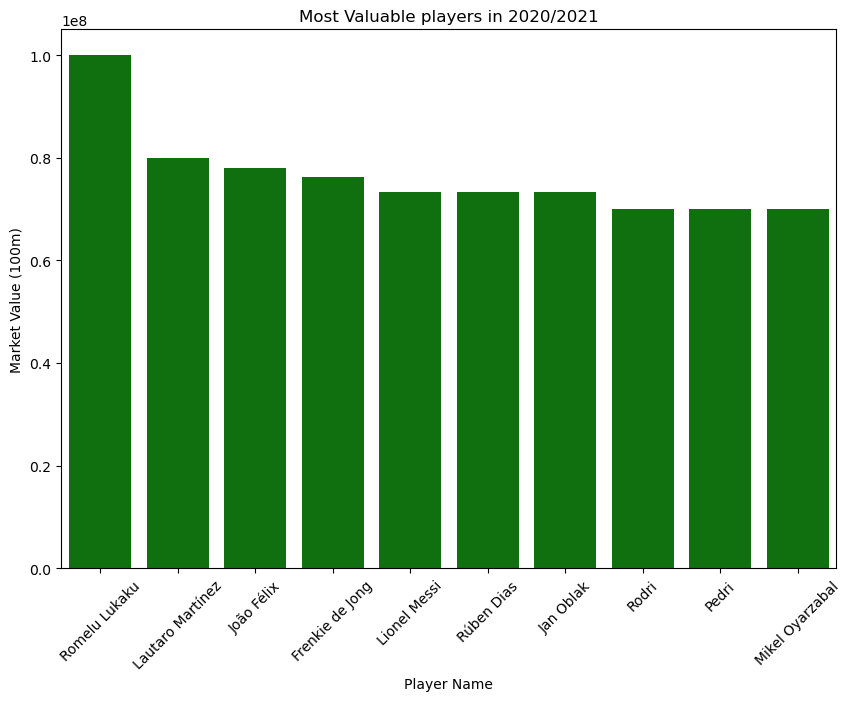

In [23]:
# Most Valuable players 2023
mvp_all_years = player_df[['full_name', 'market_value_in_eur', 'season']].sort_values('market_value_in_eur', ascending = False)
for season in mvp_all_years['season'].unique(): 
    mvp_2023 = mvp_all_years[mvp_all_years['season']==season].head(10)
    plt.figure(figsize = (10,7))
    sns.barplot(data=mvp_2023, x='full_name', y='market_value_in_eur', color = 'green')
    plt.xticks(rotation = 45)
    plt.xlabel('Player Name')
    plt.ylabel('Market Value (100m)')
    plt.title(f'Most Valuable players in {season}')
plt.show()

#### Insights
- We can see that the most valuable players vary year on year
- This analysis considers the past three years of players, in the top 7 leagues (Spain, England, Germany, Portugal, Germany, Holland, and Italy)

### Deep Dive into Erling Haaland & Kylian Mbappe: The two most valuable players

Review the most expensive players and get an initial view of what makes them expensive. 

The below analysis focuses on a key set of statistics, summarising statistics that are vital for each position. Considering defensive attributes, passing attributes, and scoring attributes. 

The plots show two things: 
- Their absolute statistics in the 2022/2023 season (the numbers on the graph)
- Their percentile statistics, calculated relative to the statistics of all other players in our data (the width of the 'slices' on the graph, where wider is equal to a higher percentile)

(The code for the plots has been sourced and amended from 'Soccermatics')

In [24]:
# Erling Haaland
haaland = player_df_reduced.loc[player_df_reduced["full_name"] == "Erling Haaland"]
haaland = haaland.loc[haaland['season']=='2022/2023']
haaland = haaland[['npxg_per_90_overall', "goals_per_90_overall", "assists_per_90_overall", "key_passes_per_90_overall",
                   "dribbles_per_90_overall", "shots_on_target_per_90_overall", 
                   "duels_won_per_90_overall", "aerial_duels_won_per_90_overall"]]
per_90_columns = haaland.columns[:]
values = [round(haaland[column].iloc[0],2) for column in per_90_columns]
percentiles = [int(stats.percentileofscore(player_df_reduced[column], haaland[column].iloc[0])) for column in per_90_columns]

In [25]:
# Kylian Mbappe
mbappe = player_df_reduced.loc[player_df_reduced["full_name"] == "Kylian Mbappé"]
mbappe = mbappe.loc[mbappe['season']=='2022/2023']
mbappe = mbappe[['npxg_per_90_overall', "goals_per_90_overall", "assists_per_90_overall", "key_passes_per_90_overall",
                   "dribbles_per_90_overall", "shots_on_target_per_90_overall", 
                   "duels_won_per_90_overall", "aerial_duels_won_per_90_overall"]]
per_90_columns1 = mbappe.columns[:]
values1 = [round(mbappe[column].iloc[0],2) for column in per_90_columns1]
percentiles1 = [int(stats.percentileofscore(player_df_reduced[column], mbappe[column].iloc[0])) for column in per_90_columns1]

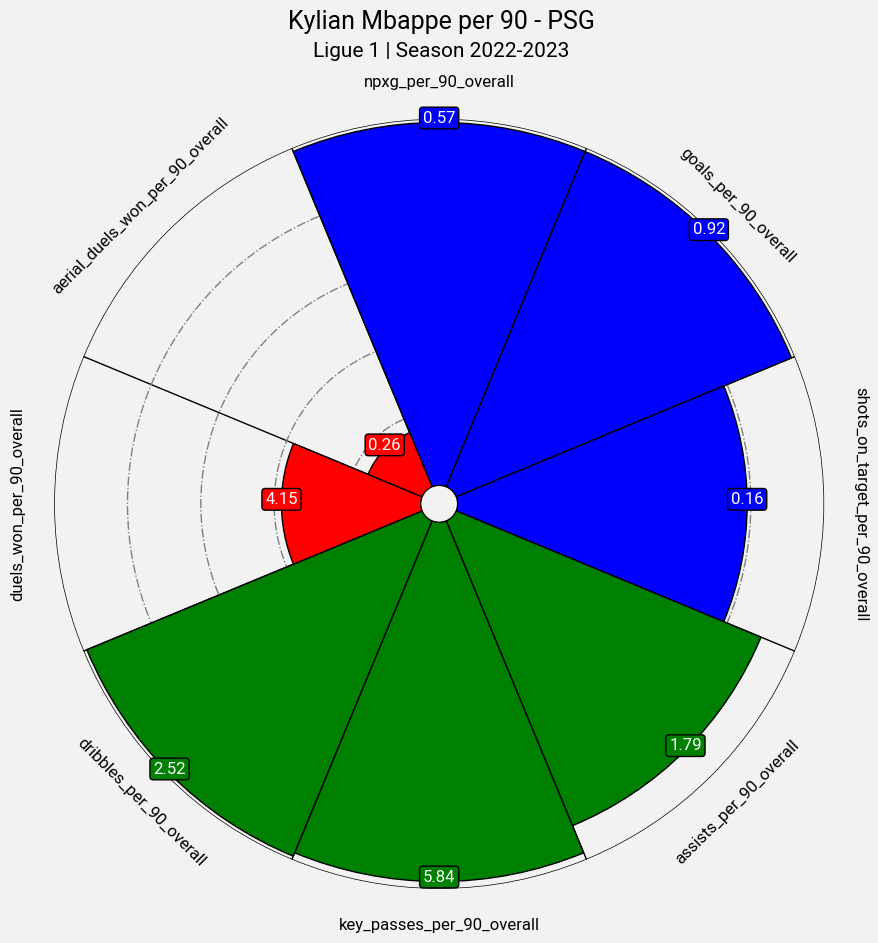

In [26]:
#list of names on plots
names = ['npxg_per_90_overall', "goals_per_90_overall","shots_on_target_per_90_overall",
         "assists_per_90_overall", "key_passes_per_90_overall","dribbles_per_90_overall",  
                   "duels_won_per_90_overall", "aerial_duels_won_per_90_overall"]
slice_colors = ["blue"] * 3 + ["green"] * 3 + ["red"] * 2
text_colors = ["white"]*8
font_normal = FontManager()

font_bold = FontManager()

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles1,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values1[i]))
# add title
fig.text(
    0.515, 0.97, "Kylian Mbappe per 90 - PSG", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Ligue 1 | Season 2022-2023",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

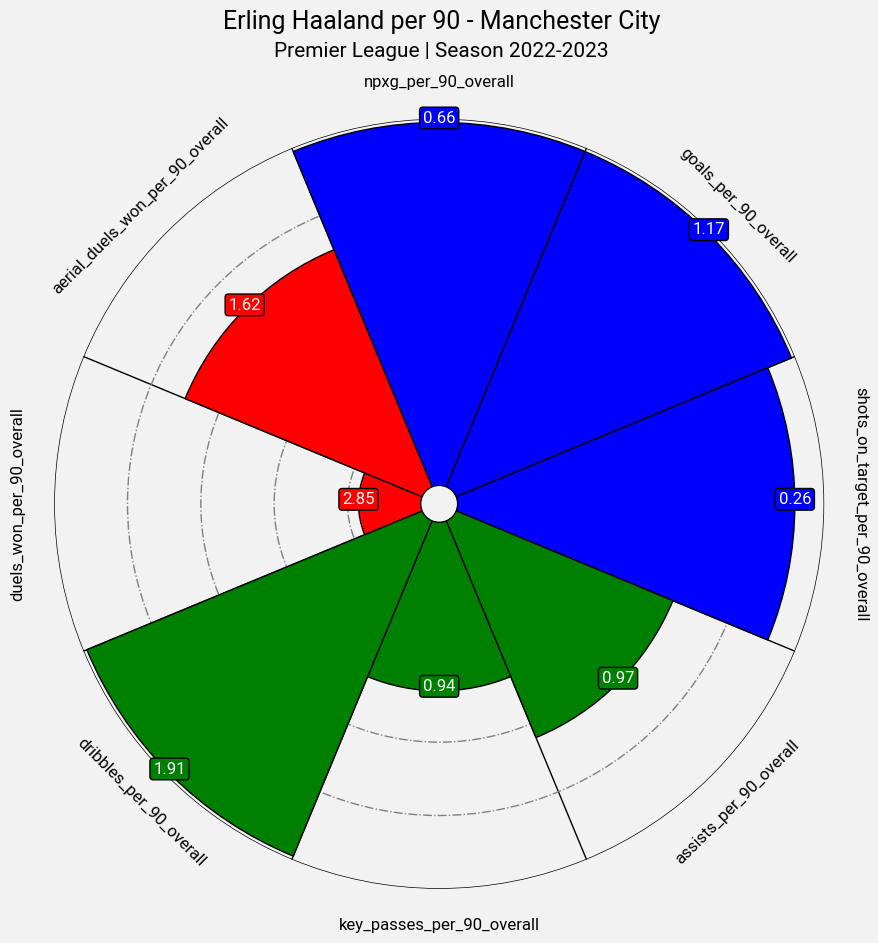

In [27]:
#list of names on plots
names = ['npxg_per_90_overall', "goals_per_90_overall","shots_on_target_per_90_overall",
         "assists_per_90_overall", "key_passes_per_90_overall","dribbles_per_90_overall",  
                   "duels_won_per_90_overall", "aerial_duels_won_per_90_overall"]
slice_colors = ["blue"] * 3 + ["green"] * 3 + ["red"] * 2
text_colors = ["white"]*8
text_colors = ["white"]*8
font_normal = FontManager()

font_bold = FontManager()

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Erling Haaland per 90 - Manchester City", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2022-2023",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

### Insights
- With consideration for all positions in football goals per 90 minutes and expected goals per 90 minutes seem to be large drivers of value (as expected) 
- The caveat is that this considers their percentile across all football positions. We would not expect goals per 90 minutes to be the most important factor for a defender for example. This will be further analysed in this analysis. 


### Univariate Analysis: Numeric Columns

In [28]:
# Check column data types - all look as expected
player_df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5974 entries, 0 to 8049
Data columns (total 72 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   full_name                               5974 non-null   object 
 1   age                                     5974 non-null   int64  
 2   league                                  5974 non-null   object 
 3   season                                  5974 non-null   object 
 4   position                                5974 non-null   object 
 5   Current Club                            5974 non-null   object 
 6   nationality                             5974 non-null   object 
 7   file_name                               5974 non-null   object 
 8   player_year_key                         5974 non-null   object 
 9   minutes_played_overall                  5974 non-null   float64
 10  appearances_overall                     5974 non-null   float64
 

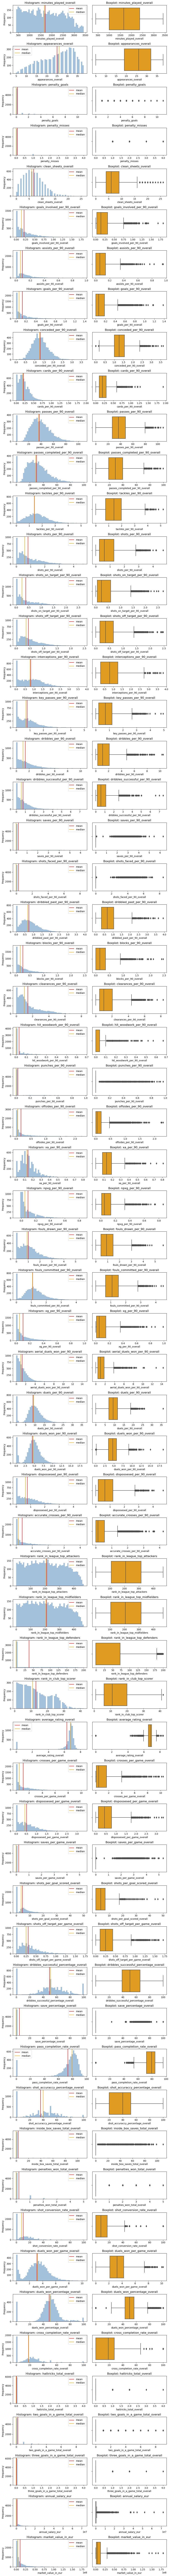

In [29]:
# List of numeric columns to review individual distribution of each variable
numeric_columns = player_df_reduced.select_dtypes(include=['float64'])
len(numeric_columns.columns)
plt.subplots(63, 2, figsize=(10, 150))

i = 1
j = 2
for column in numeric_columns: 
    plt.subplot(63, 2, i)
    plt.hist(player_df_reduced[column], color="steelblue", alpha=0.5, bins=50)
    plt.axvline(player_df_reduced[column].mean(), color = 'red', label = 'mean')
    plt.axvline(player_df_reduced[column].median(), color = 'orange', label = 'median')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram: {column}')
    plt.legend()
    
    plt.subplot(63, 2, j)
    sns.boxplot(x = player_df_reduced[column], palette=["orange", "steelblue"])
    plt.title(f'Boxplot: {column}')
    
    i+=2
    j+=2
plt.tight_layout()
plt.show() 

In [30]:
# Describe the numeric columns
numeric_columns.describe()

minutes_played_overall  appearances_overall  penalty_goals  \
count             5974.000000          5974.000000    5974.000000   
mean              1702.777034            25.002511       0.227486   
std                804.687609             8.044525       0.864680   
min                401.000000             5.000000       0.000000   
25%               1001.000000            19.000000       0.000000   
50%               1659.000000            26.000000       0.000000   
75%               2372.750000            32.000000       0.000000   
max               3420.000000            38.000000      11.000000   

       penalty_misses  clean_sheets_overall  goals_involved_per_90_overall  \
count     5974.000000           5974.000000                    5974.000000   
mean         0.062772              6.726314                       0.212667   
std          0.294904              3.913289                       0.229144   
min          0.000000              0.000000                       0.000000   
25%          0.000000              4.000000                       0.030000   
50%          0.000000              6.000000                       0.140000   
75%          0.000000              9.000000                       0.320000   
max          4.000000             26.000000                       1.820000   

       assists_per_90_overall  goals_per_90_overall  conceded_per_90_overall  \
count             5974.000000           5974.000000              5974.000000   
mean                 0.087792              0.124851                 1.296249   
std                  0.107645              0.166792                 0.433262   
min                  0.000000              0.000000                 0.000000   
25%                  0.000000              0.000000                 1.000000   
50%                  0.060000              0.060000                 1.260000   
75%                  0.140000              0.180000                 1.550000   
max                  0.960000              1.380000                 3.630000   

       cards_per_90_overall  ...  penalties_won_total_overall  \
count           5974.000000  ...                  5974.000000   
mean               0.211779  ...                     0.198694   
std                0.160869  ...                     0.530211   
min                0.000000  ...                     0.000000   
25%                0.100000  ...                     0.000000   
50%                0.190000  ...                     0.000000   
75%                0.300000  ...                     0.000000   
max                1.930000  ...                     5.000000   

       shot_conversion_rate_overall  duels_won_per_game_overall  \
count                   5974.000000                 5974.000000   
mean                      10.358467                    3.145139   
std                       12.356764                    1.708489   
min                        0.000000                    0.000000   
25%                        0.000000                    2.150000   
50%                        7.690000                    3.240000   
75%                       17.177500                    4.250000   
max                      100.000000                   10.240000   

       duels_won_percentage_overall  cross_completion_rate_overall  \
count                   5974.000000                    5974.000000   
mean                      48.952203                      18.259608   
std                       17.583575                      17.634049   
min                        0.000000                       0.000000   
25%                       43.380000                       0.000000   
50%                       50.325000                      18.520000   
75%                       56.817500                      27.582500   
max                      100.000000                     100.000000   

       hattricks_total_overall  two_goals_in_a_game_total_overall  \
count              5974.000000                        5974.000000   
me

#### Insights:  Numerical Variables: 
- There were significant outliers in the data, reducing the dataframe to only include players who have played a minimum amount of game time has significanty reduced them

- The plots consider players of all positions, each position has a different role / expectation of performance and therefore not all plots are directly representative of this. 
    - For example, the log normal distributions may become more normal when considering only the position they are relavant for. A position specific analysis and modelling will be performed to address this. 

- The variables follow different distributions, some are log normal, others more normally distributed, this will be considered further in the analysis and in model selection / feature engineering.

- There are gaps in some columns e.g. annual_salary_eur which should be present for all players

- A number of variables have zero values, in some cases this is expected e.g. A goalkeeper and scoring goals, or a defender who has not taken any shots. This will be carried for this analysis. 


#### Categorical Variables

In [31]:
# Identify categorical variables (note Nationality and Club have been excluded due to colume)
categorical_columns = player_df_reduced.select_dtypes(exclude=['int', 'float'])              
categorical_columns.drop(columns = ['nationality', 'Current Club','full_name', 'file_name', 'player_year_key'], inplace = True)

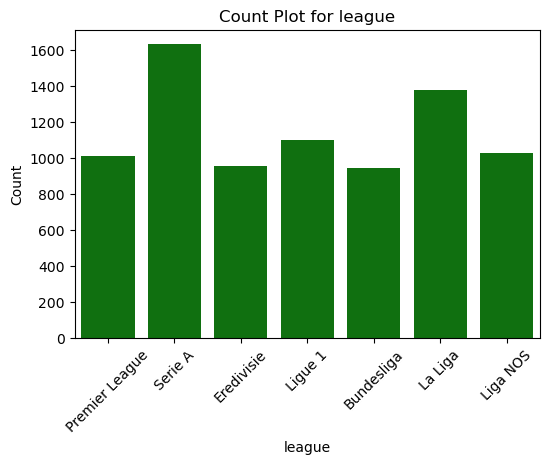

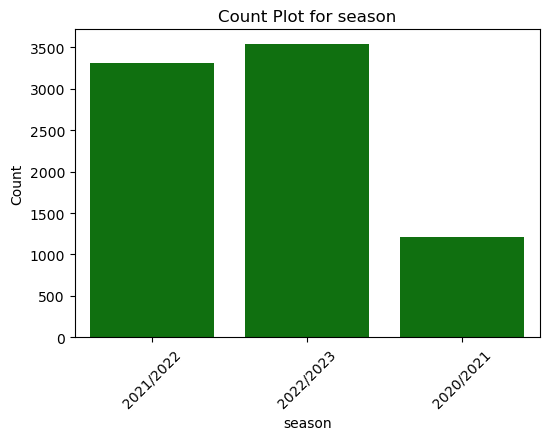

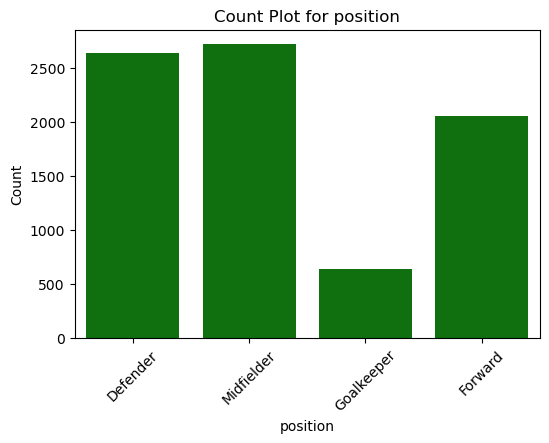

In [32]:
# Plot for each categorical variable
for column in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=column, data=player_df, color= 'green')
    plt.title(f'Count Plot for {column}')
    plt.xlabel(f'{column}')
    plt.xticks(rotation = 45)
    plt.ylabel('Count')
    plt.show()

#### Insights: 
- League: There is a relatively even distribution of players within each league
- Season: There is a drop off in the number of players in the 2021/2022 season. This is due to missing data for certain leagues. This will be carried in the analysis to allow for more data in our modelling of market value. 
- Position: This is currently only broken down into four positions in the data set, in reality there are significantly more positions in football: Goalkeeper, Centre Back, Right/Left Back, Central Midfielder, Attacking Midfielder, Winger, Striker (and other more niche positions). I will look into clustering to try to idenfify these positions from the statistics later in the analysis

## Perform Bivariate Analysis 

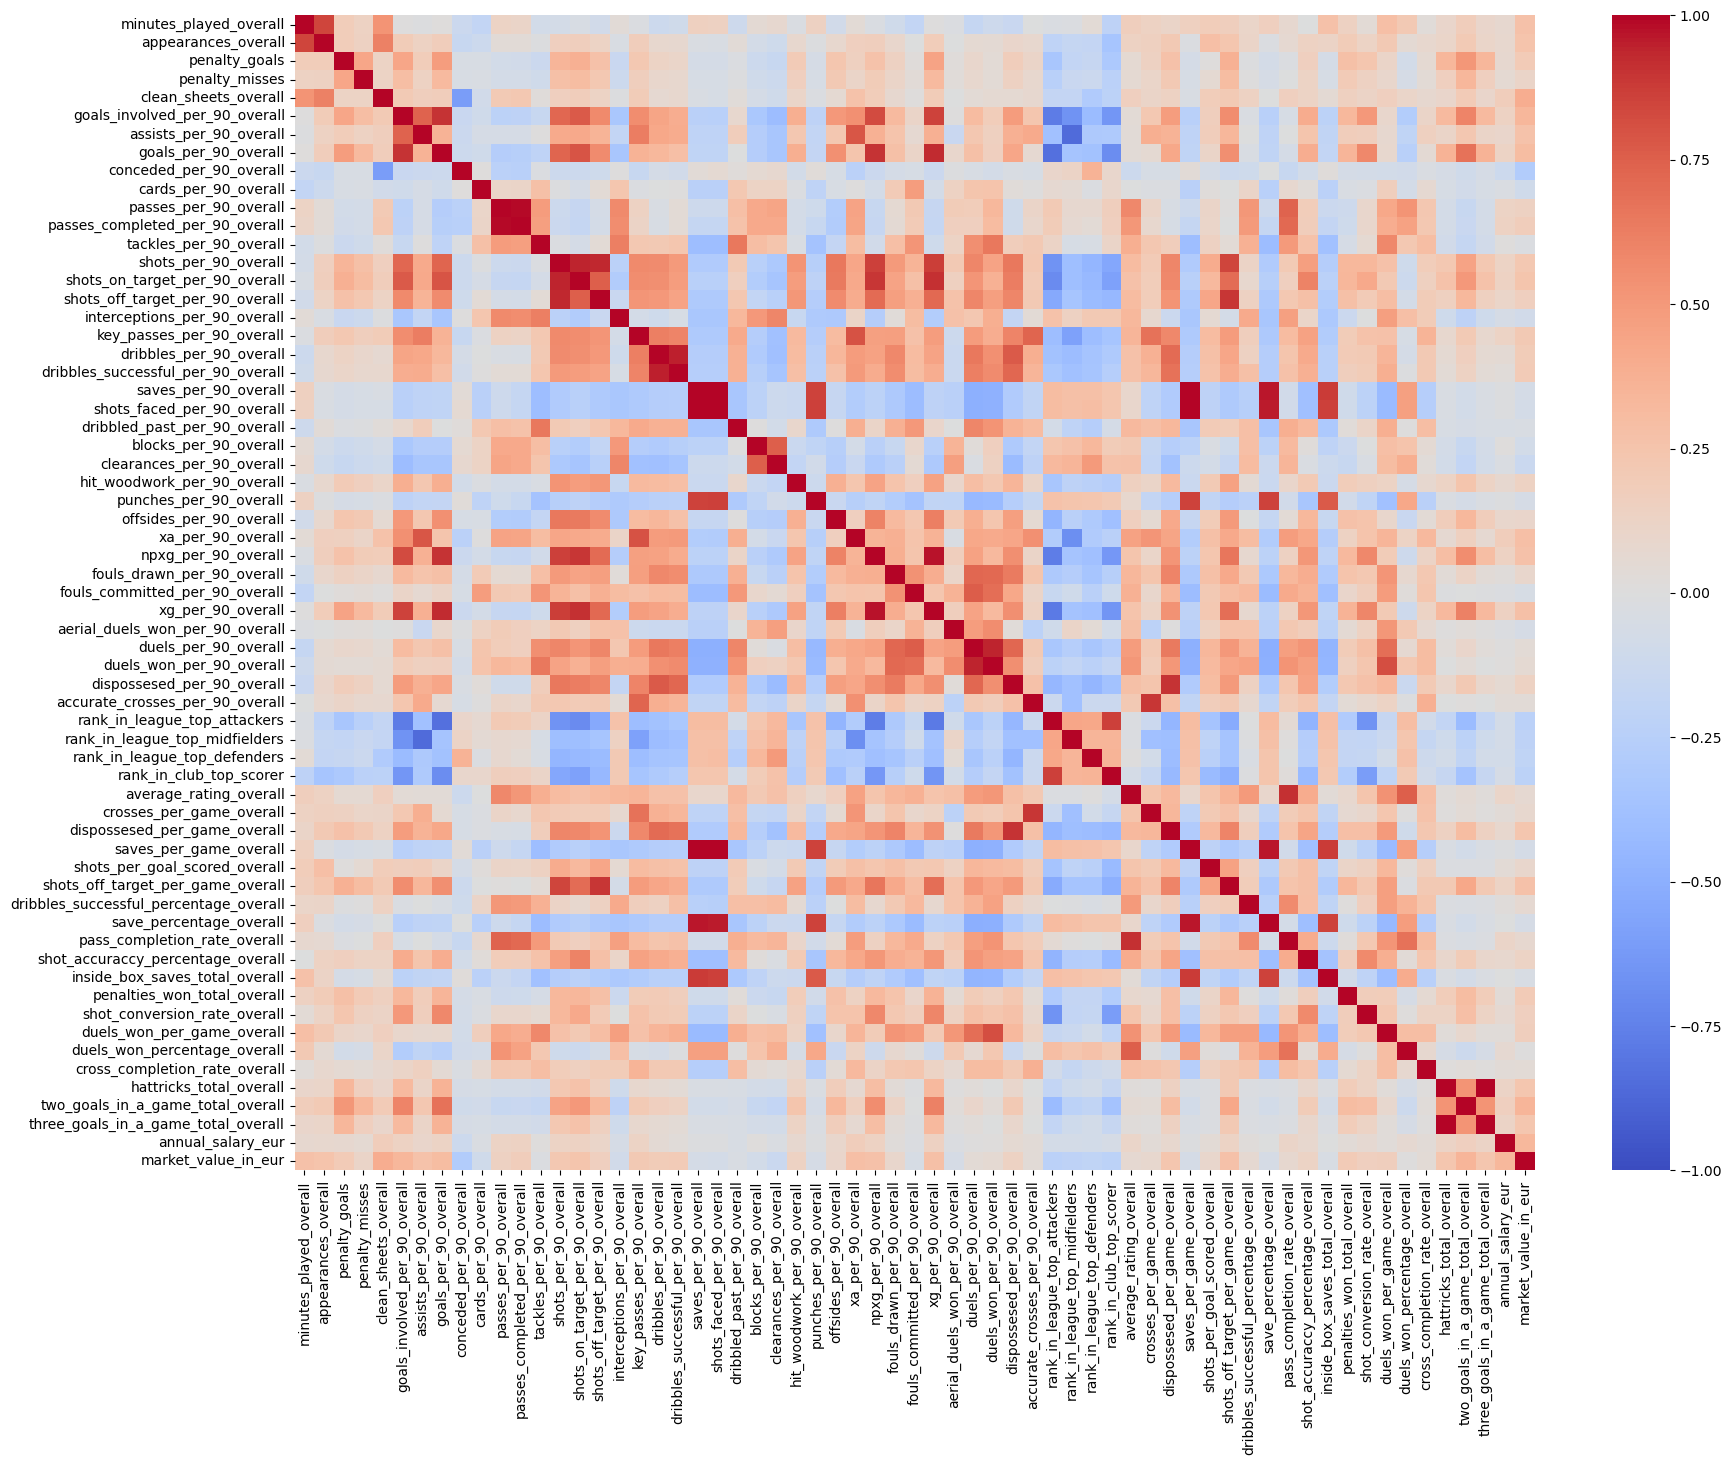

In [33]:
# Review for colinearity within the variables
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_columns.corr(), cmap="coolwarm", vmax=1.0, vmin=-1.0)
plt.show()

There is colinearity within the data set, this is expected as multiple variables will correlate with one another e.g. rank in top midfielders vs assists per 90. We would expect better midfielders to have more assists. 

At this stage, the colinearity has been left as-is. The variables are useful to identify which are the largest drivers of value, but also during players identification and comparison. 

### Review numerical variables vs target

62


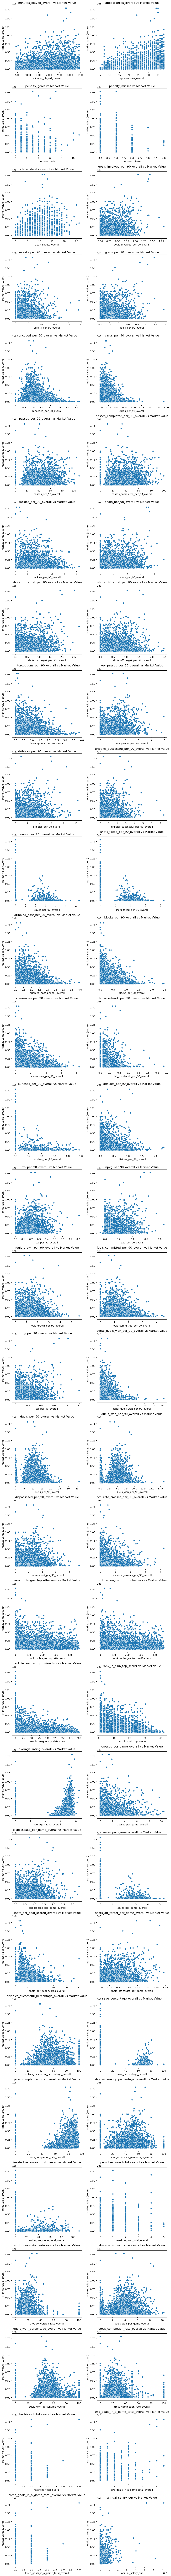

In [34]:
# Create scatter graphs to review relationships between dependent and independent variables
independent_numeric = numeric_columns.iloc[:, :-1]  
target = numeric_columns.iloc[:, -1]
independent_columns = independent_numeric.columns
print(len(independent_columns))
i=1

plt.subplots(31, 2, figsize=(10, 150))
for column in independent_columns: 
    plt.subplot(31, 2, i)
    sns.scatterplot(x=independent_numeric[column], y=target)
    plt.xlabel(column)
    plt.ylabel('Market Value (100m)')
    plt.title(f'{column} vs Market Value')
    i+=1

plt.tight_layout()
plt.show()

#### Insights
- Some linear relationships are evident (positive and negative): 

    - Appearances
    - shot conversion rate
    - Inside the box saves
    - Pass Completion Rate
    - Save %
    - Shots per goal
    - Dribble success %
    - Saves per Game
    - Crosses per Game
    - Average rating
    - Ranking in league top attackers / midfielders / defenders / goalkeepers
    - etc, etc
  
  
- The caveat is these relationships are identified across all positions and are distorted. E.g. striker market values will be distorting the metrics specific to a goalkeeper. 

- Due to volume I will assess correlation coefficients

### Correlation Coefficients and Statistical Signifcance

In [35]:
# Check correlation and statistical significance of p-values
results = []
for i in independent_columns: 
    stat_sig = stats.pearsonr(independent_numeric[i], target)
    results.append((i, stat_sig[0], stat_sig[1]))

results_df = pd.DataFrame(results,
                         columns = ['Features', 'Correlation Coefficient', 'P-Value'])

results_df['Statistically Significant'] = np.where(results_df['P-Value']<0.05, 'Statistically Significant', 'Not Statistically Significant')
sorted_df_corr_coef = results_df.sort_values('Correlation Coefficient')

In [36]:
# Statistical significance
sorted_df_corr_coef.sort_values('Statistically Significant').head(10)

Features  Correlation Coefficient        P-Value  \
56     duels_won_percentage_overall                 0.000503   9.690118e-01   
12           tackles_per_90_overall                -0.017404   1.786151e-01   
8           conceded_per_90_overall                -0.282839  2.721878e-110   
36       dispossesed_per_90_overall                 0.138487   5.707366e-27   
10            passes_per_90_overall                 0.146314   6.056141e-30   
54     shot_conversion_rate_overall                 0.156265   5.725692e-34   
15  shots_off_target_per_90_overall                 0.163316   5.494542e-37   
55       duels_won_per_game_overall                 0.171712   9.233508e-41   
11  passes_completed_per_90_overall                 0.173362   1.586383e-41   
18          dribbles_per_90_overall                 0.187861   1.395105e-48   

        Statistically Significant  
56  Not Statistically Significant  
12  Not Statistically Significant  
8       Statistically Significant  
36      Statistically Significant  
10      Statistically Significant  
54      Statistically Significant  
15      Statistically Significant  
55      Statistically Significant  
11      Statistically Significant  
18      Statistically Significant

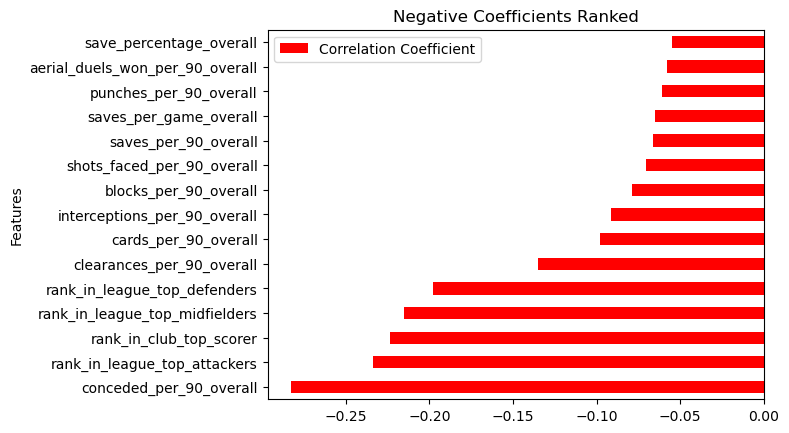

In [37]:
# Negative Coefficients (top 15)
sorted_df_corr_coef[['Features', 'Correlation Coefficient']].set_index('Features').head(15)\
.plot(kind = 'barh', color = 'red')
plt.title('Negative Coefficients Ranked')
plt.show()

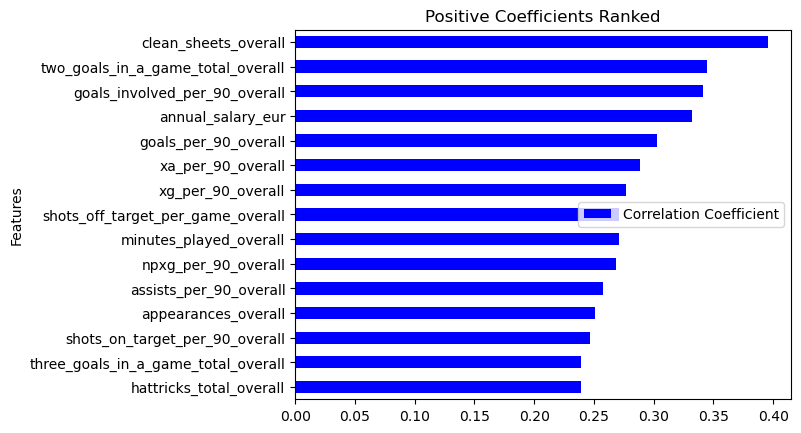

In [38]:
# Negative Coeffients (top 15)
sorted_df_corr_coef[['Features', 'Correlation Coefficient']].set_index('Features').tail(15)\
.plot(kind = 'barh', color = 'blue')
plt.title('Positive Coefficients Ranked')
plt.show()

- We can start to see which variables have the largest impact and relationship with the target. 
- Clean sheets, is the most correlated with a high market value, interestingly this is a proxy for playing in a 'good' team. This is not necessarily an individual statistic but playing in a good team is also a driver of market value which is expected. 
- Some variables show positive / negative relationships, in some cases the inverse of the coefficients will drive the market value due to the nature of the variables (inverse) e.g. rank in club top scorer. This is actually the largest correlator of a higher market value even though it is in the negative coefficients. 
- This needs to be taken with caution, we are looking at the target variable inclusive of all player positions. We would expect different relationships if only considering specific variables vs specific position market values. e.g. shots on target is not a driver of a goalkeeper market value. 

### Categorical Variables vs Target

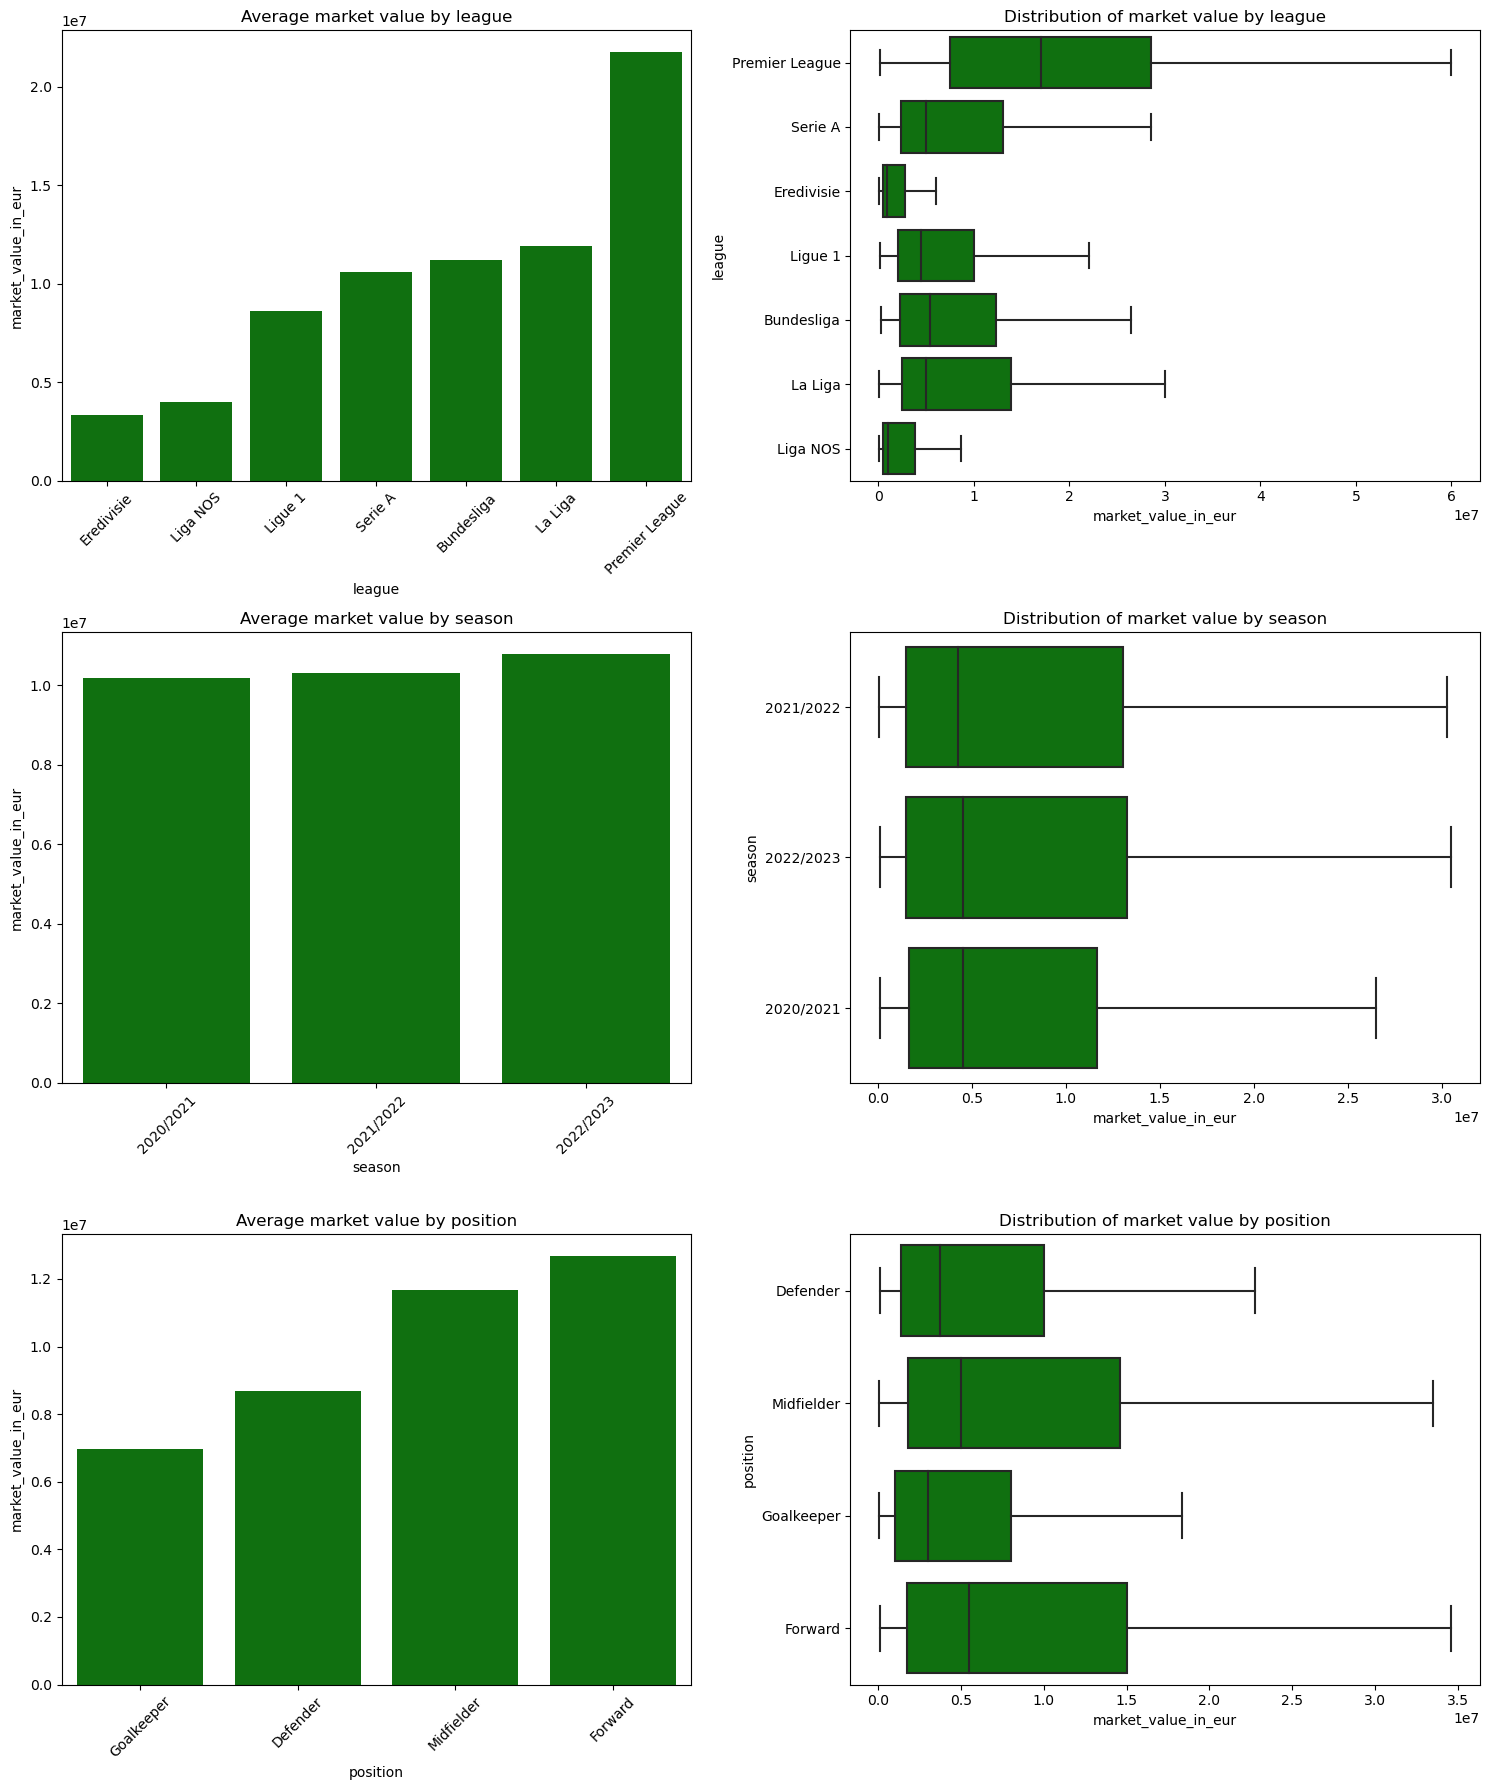

In [47]:
# Categories to review
plt.subplots(3, 2, figsize=(15,18))
i = 1
j = 2
for column in categorical_columns: 
    plt.subplot(3, 2, i)
    mean = player_df_reduced.groupby(column)['market_value_in_eur']\
    .mean().reset_index().sort_values('market_value_in_eur')
    sns.barplot(data=mean, x=column, y='market_value_in_eur', color='green'),
    plt.title(f'Average market value by {column}')
    plt.xticks(rotation = 45)
    
    plt.subplot(3, 2, j)
    sns.boxplot(data=player_df_reduced, x='market_value_in_eur', y=column, showfliers=False, color = 'green'),
    plt.title(f'Distribution of market value by {column}')
    
    i+=2
    j+=2

plt.tight_layout()    
plt.show()

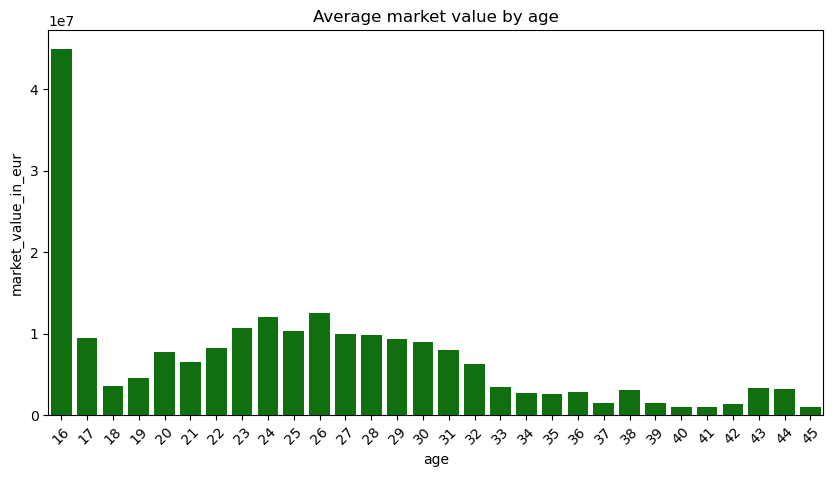

In [41]:
# Age as a categorical variable
plt.figure(figsize = (10,5))
mean = player_df_dropped.groupby('age')['market_value_in_eur']\
.mean().reset_index().sort_values('market_value_in_eur')
sns.barplot(data=mean, x='age', y='market_value_in_eur', color='green'),
plt.title(f'Average market value by age')
plt.xticks(rotation = 45)
plt.show()

### Insights
- I have considered both the mean of the target variables by category, and the distribution of the target variables by category
- Both position, and league will have a significant impact on the market value of the players (descriminatory)
    - Interestingly the premier league has by far the highest median value and has significantly more higher value players than the other leagues
    - Forwards and midfielders tend to be the most expensive players
- Season / year has not had a big impact over the last three years, this is good for the analysis (not a noticable trend / change over the last three seasons on average)
- I will also look at fscores for the other categories utilising ANOVA 
- Age will also be descriminatory and will be explored in feature engineering

### Additional EDA questions (Market Value): 
1. How has market value by position changed over time?  
2. How has the valuation of players of different ages changed over time?
3. How does age and impact market value? 

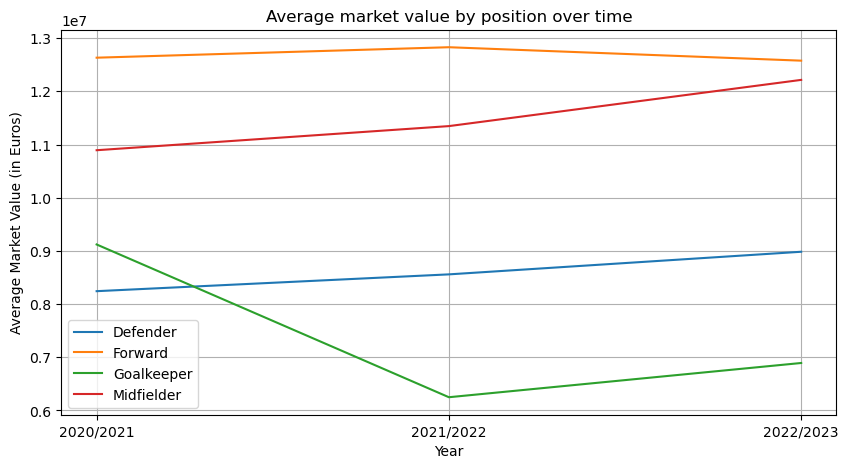

In [42]:
# How has the market value by position changed over time? 
position_value_time = player_df_reduced.groupby(['position', 'season'])['market_value_in_eur'].mean().reset_index()

plt.figure(figsize = (10,5))

for position in position_value_time['position'].unique():
    data = position_value_time[position_value_time['position']==position]
    plt.plot(data['season'], data['market_value_in_eur'], label=position)

plt.xlabel('Year')
plt.ylabel('Average Market Value (in Euros)')
plt.title('Average market value by position over time')
plt.legend()
plt.grid(True)

#### Insights
- Although only a small timeframe, some initial trends can be identified: 
    - Midfielders have been increasing in average value year over year
    - Forwards have always been the most expensive but midfielders are closing the gap 
    - Defenders, followed by goalkeepers tend to be the least expensive position 

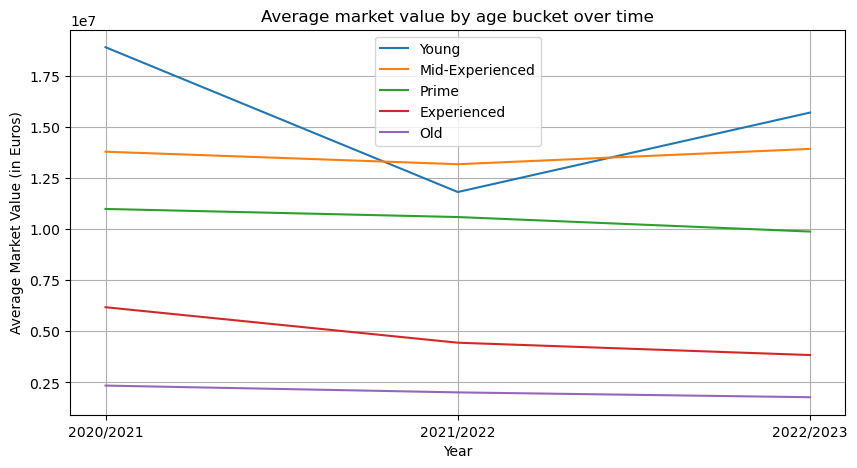

In [43]:
# 2. How has the valuation of players of different ages changed over time? 
age_bucket_df = player_df_reduced.copy()
age_bucket_df['Age Buckets'] = pd.cut(age_bucket_df['age'], bins=[15,21,26,31,36,50], 
labels=['Young','Mid-Experienced', 'Prime', 'Experienced', 'Old'])

age_value_time = age_bucket_df.groupby(['Age Buckets', 'season'])['market_value_in_eur'].mean().reset_index()

plt.figure(figsize = (10,5))

for bucket in age_value_time['Age Buckets'].unique():
    data = age_value_time[age_value_time['Age Buckets']==bucket]
    plt.plot(data['season'], data['market_value_in_eur'], label=bucket)

plt.xlabel('Year')
plt.ylabel('Average Market Value (in Euros)')
plt.title('Average market value by age bucket over time')
plt.legend()
plt.grid(True)

#### Insights
- Although only a small timeframe, some initial trends can be identified: 
    - The youngest players (15-21) on average are the most expensive and increased YoY from 2021/2022 - 2022/2023
    - Mid Experiences (21-26) are the second most expensive
    - The average value then reduces as age increases

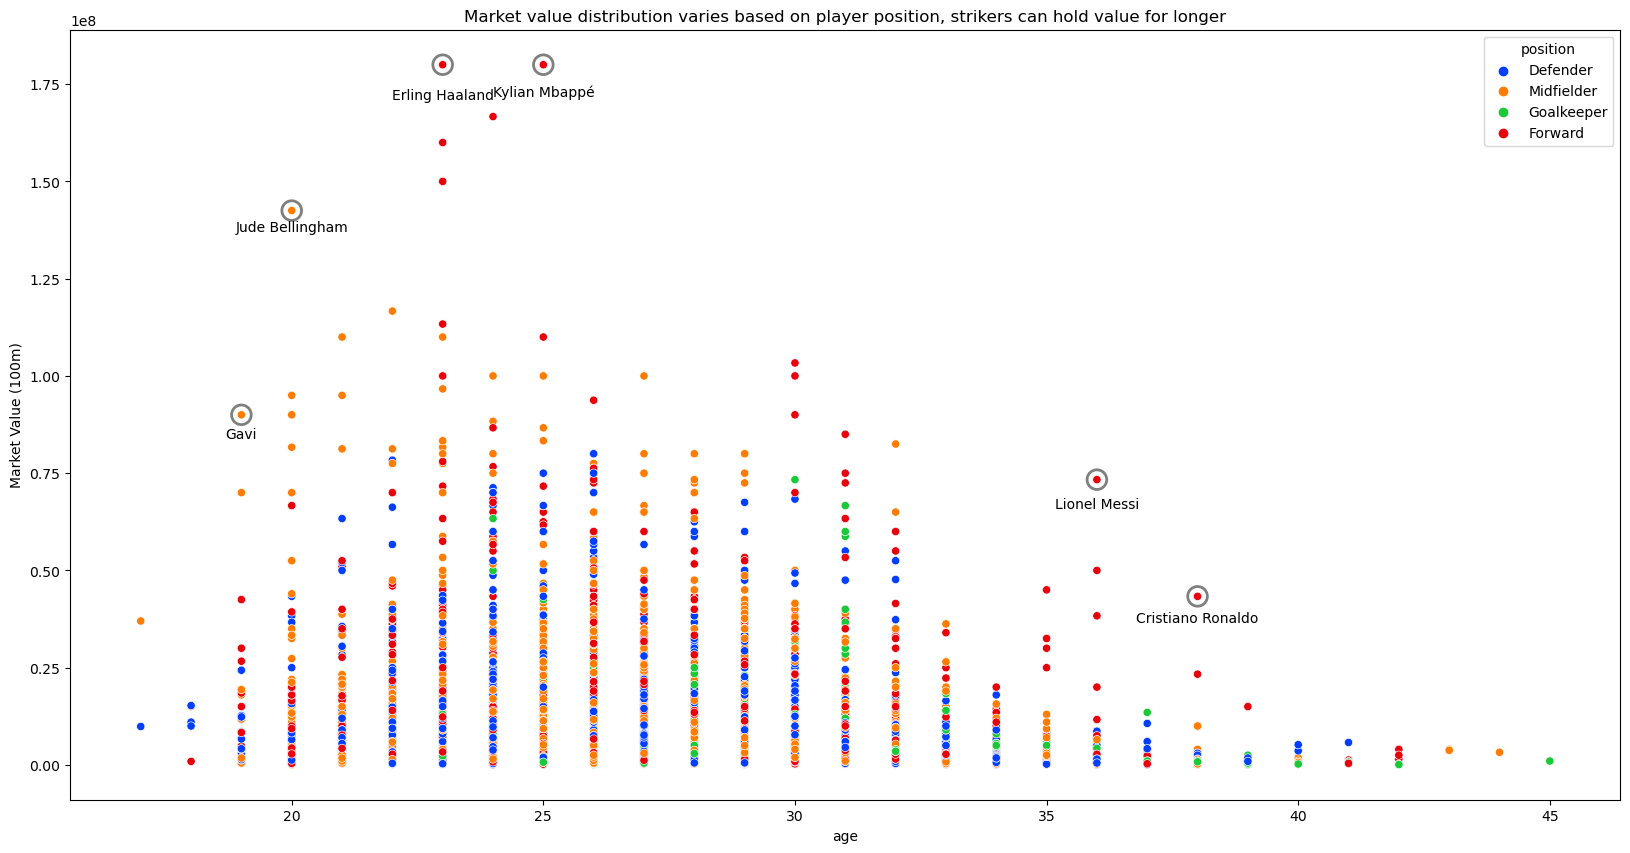

In [44]:
# How does age and position impact market value?

top_5_value = list(player_df_reduced.sort_values('market_value_in_eur', ascending = False).iloc[:2,].index)
old_but_valuable1 = list(player_df_reduced[player_df_reduced['age']==36].sort_values('market_value_in_eur', ascending = False).head(1).index)
old_but_valuable2 = list(player_df_reduced[player_df_reduced['age']==38].sort_values('market_value_in_eur', ascending = False).head(1).index)
young_but_valuable1 = list(player_df_reduced[player_df_reduced['age']==19].sort_values('market_value_in_eur', ascending = False).head(1).index)
young_but_valuable2 = list(player_df_reduced[player_df_reduced['age']==20].sort_values('market_value_in_eur', ascending = False).head(1).index)

plt.figure(figsize = (20, 10))
sns.scatterplot(data = player_df_reduced, x= 'age', y = 'market_value_in_eur', hue = 'position', palette='bright')

indices_to_circle = top_5_value + old_but_valuable1 + old_but_valuable2 + young_but_valuable1 + young_but_valuable2

# Extract the coordinates of the points to circle
x_points = player_df_reduced['age'][indices_to_circle]
y_points = player_df_reduced['market_value_in_eur'][indices_to_circle]
player_names = player_df_reduced.loc[indices_to_circle]['full_name']

for i, (x, y, txt) in enumerate(zip(x_points, y_points, player_names)):
    y_offset = -25 + i*2 
    plt.annotate(txt, (x, y), textcoords="offset points", xytext=(0, y_offset), ha='center')

# Plot circles around the specified data points
plt.scatter(x_points, y_points, color='none', s=200, alpha=0.5, edgecolor='black', linewidth=2)
plt.title('Market value distribution varies based on player position, strikers can hold value for longer')
plt.ylabel('Market Value (100m)')
plt.show()

#### Insights
- This graphic looks at the market value of all players based on their age, with colours indicating their position. 

Some interesting insights: 
- Value and age follow a roughly normal distribution, centering around the age of 26 as the peak value
- Forwards can have the most extreme values, particularly when less than 25, identified with the circles on Erling Haaland and Kylian Mbappe
- A pocket of very expensive, young midfielers exists between 20 and 25 suggesting these players are in high demand, otherwise they follow a relatively normal distribution 
- Forwards tend to keep their value for longest and can still be valuable at the age of 30 onwards
- Similarly, goalkeepers can still hold high values at a later age 
- Defenders follow a more normal distribution around a centre of around 26

### Conclusion

#### The EDA has identified a number of considerations:
   -  Statistics have different relationships with the target (log-normal / normal / other), models will be considered based on their ability to handle this and transformations considered
   - Market Value: The target variable has a log normal distribution - this is a consideration for transformation in modelling. 
   - Age: is a key driver for market value, following a roughly normal distribution and should be considered / engineered to reflect this in modelling
   - Position: Massively impacts market value of a player, position statistics are also position specific, a baseline model will be created for all positions, subsequently a position specific model will be created. 
   - League: Which league you play in is also a huge factor - The premier league has the highest value players by far compared to other leagues. 
   - High Positive Correlation Features Identified: Clean Sheets Overall, Two Goals in a Game, Goals involved per 90, Salary, Goals per 90
   - High Negative Correlation Features Idenfified: Conceded Per 90 (Representative of playing for a less good team), Rank by position (this is actually an inverse, a low rank, is a high positive correlation), Clearances per 90, Cards per 90, interceptions per 90, shots faced per 90
      - These look to be defensive and goalkeeping attributes, the correlation is considering all players within the data frame of all positions, therefore we would expect defensive attributes to correlate to a lower value as defenders and goalkeepers on average are valued less than other positions. This again makes the case for positional specific models. 
      
#### Next Steps: 
- Feature Engineering:
    - Encoding of categorical variables
    - Encoding of age - One Hot Encoding to be considered
    - Analysis of individual positions and the relationship with the target variable (exlcuding other positions in the analysis) 
    - Consideration of Transformation of Target Variable to a Log Normal distribution 
- Modelling: 
    - Baseline modelling with players of all positions, then consideration on specific models by position 

### APPENDIX: Identify outliers

In [558]:
def z_score_outliers (df, threshold=9): 
    player_df_no_outliers = df.copy()
    for column in player_df_no_outliers.columns: 
        individual_columns = player_df_no_outliers[column]
        z_scores = np.abs((individual_columns - np.mean(individual_columns)) / np.std(individual_columns))
        outliers = z_scores > threshold
        col_mean = np.mean(individual_columns[~outliers])
        player_df_no_outliers.loc[outliers,column]=col_mean
    return player_df_no_outliers

In [559]:
num_cols_exluding_target = player_df_reduced.select_dtypes('float').iloc[:,:-1]

In [560]:
num_cols_exluding_target.sort_values('goals_per_90_overall', ascending = False)

minutes_played_overall  appearances_overall  penalty_goals  \
4466                  1434.0                 36.0            2.0   
1538                  1986.0                 28.0            4.0   
2085                  2779.0                 35.0            7.0   
6454                  2952.0                 34.0            5.0   
5961                  2094.0                 27.0            1.0   
...                      ...                  ...            ...   
2430                  1214.0                 14.0            0.0   
2429                  1710.0                 19.0            0.0   
5533                  1808.0                 26.0            0.0   
5534                   766.0                 19.0            0.0   
8049                   554.0                 10.0            0.0   

      penalty_misses  clean_sheets_overall  goals_involved_per_90_overall  \
4466             1.0                  10.0                           1.82   
1538             0.0                  10.0                           1.36   
2085             0.0                  12.0                           1.42   
6454             0.0                  11.0                           1.16   
5961             1.0                   5.0                           1.16   
...              ...                   ...                            ...   
2430             0.0                   3.0                           0.00   
2429             0.0                   3.0                           0.00   
5533             0.0                   8.0                           0.00   
5534             0.0                   4.0                           0.00   
8049             0.0                   2.0                           0.00   

      assists_per_90_overall  goals_per_90_overall  goals_per_90_away  \
4466                    0.44                  1.38               1.56   
1538                    0.18                  1.18               1.28   
2085                    0.26                  1.17               0.86   
6454                    0.09                  1.07               1.18   
5961                    0.13                  1.03               1.01   
...                      ...                   ...                ...   
2430                    0.00                  0.00               0.00   
2429                    0.00                  0.00               0.00   
5533                    0.00                  0.00               0.00   
5534                    0.00                  0.00               0.00   
8049                    0.00                  0.00               0.00   

      conceded_per_90_overall  ...  inside_box_saves_total_overall  \
4466                     1.19  ...                             0.0   
1538                     0.77  ...                             0.0   
2085                     0.78  ...                             0.0   
6454                     1.07  ...                             0.0   
5961                     1.46  ...                             0.0   
...                       ...  ...                             ...   
2430                     1.63  ...                            21.0   
2429                     1.74  ...                            54.0   
5533                     1.64  ...                             0.0   
5534                     2.23  ...                             0.0   
8049                     1.46  ...                             0.0   

      penalties_won_total_overall  shot_conversion_rate_overall  \
4466                          1.0                         29.33   
1538                          1.0                         37.14   
2085                          1.0                         33.96   
6454                          1.0                          0.00   
5961                          0.0                          0.00   
...                           ...                           ...   
2430                          0.0                          0.00   
2429      

In [561]:
z_score_outliers(num_cols_exluding_target).sort_values('goals_per_90_overall', ascending = False)

minutes_played_overall  appearances_overall  penalty_goals  \
4466                  1434.0                 36.0            2.0   
1538                  1986.0                 28.0            4.0   
2085                  2779.0                 35.0            7.0   
6454                  2952.0                 34.0            5.0   
5961                  2094.0                 27.0            1.0   
...                      ...                  ...            ...   
2430                  1214.0                 14.0            0.0   
2429                  1710.0                 19.0            0.0   
5533                  1808.0                 26.0            0.0   
5534                   766.0                 19.0            0.0   
8049                   554.0                 10.0            0.0   

      penalty_misses  clean_sheets_overall  goals_involved_per_90_overall  \
4466             1.0                  10.0                           1.82   
1538             0.0                  10.0                           1.36   
2085             0.0                  12.0                           1.42   
6454             0.0                  11.0                           1.16   
5961             1.0                   5.0                           1.16   
...              ...                   ...                            ...   
2430             0.0                   3.0                           0.00   
2429             0.0                   3.0                           0.00   
5533             0.0                   8.0                           0.00   
5534             0.0                   4.0                           0.00   
8049             0.0                   2.0                           0.00   

      assists_per_90_overall  goals_per_90_overall  goals_per_90_away  \
4466                    0.44                  1.38               1.56   
1538                    0.18                  1.18               1.28   
2085                    0.26                  1.17               0.86   
6454                    0.09                  1.07               1.18   
5961                    0.13                  1.03               1.01   
...                      ...                   ...                ...   
2430                    0.00                  0.00               0.00   
2429                    0.00                  0.00               0.00   
5533                    0.00                  0.00               0.00   
5534                    0.00                  0.00               0.00   
8049                    0.00                  0.00               0.00   

      conceded_per_90_overall  ...  inside_box_saves_total_overall  \
4466                     1.19  ...                             0.0   
1538                     0.77  ...                             0.0   
2085                     0.78  ...                             0.0   
6454                     1.07  ...                             0.0   
5961                     1.46  ...                             0.0   
...                       ...  ...                             ...   
2430                     1.63  ...                            21.0   
2429                     1.74  ...                            54.0   
5533                     1.64  ...                             0.0   
5534                     2.23  ...                             0.0   
8049                     1.46  ...                             0.0   

      penalties_won_total_overall  shot_conversion_rate_overall  \
4466                          1.0                         29.33   
1538                          1.0                         37.14   
2085                          1.0                         33.96   
6454                          1.0                          0.00   
5961                          0.0                          0.00   
...                           ...                           ...   
2430                          0.0                          0.00   
2429      